In [1]:
!pip install qiskit

     |████████████████████████████████| 6.7MB 3.6MB/s 
     |████████████████████████████████| 23.4MB 68.0MB/s 
     |████████████████████████████████| 163kB 46.6MB/s 
     |████████████████████████████████| 174kB 49.4MB/s 
     |████████████████████████████████| 1.9MB 40.7MB/s 
     |████████████████████████████████| 768kB 36.2MB/s 
     |████████████████████████████████| 5.6MB 42.8MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 296kB 42.8MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 26.0MB 56.1MB/s 
     |████████████████████████████████| 573kB 39.5MB/s 
     |████████████████████████████████| 2.7MB 40.2MB/s 
  Created wheel for qiskit: filename=qiskit-0.19.2-cp36-none-any.whl size=2896 sha256=acf362fbf4ebb9838d174e1653089845941f056d943038a42580321946daefe3
  Stored in directory: /root/.cache/pip/wheels/d8/29/6e/e065f721b42fe7

In [0]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

In [0]:
class QiskitCircuit():
    def __init__(self,shots):
        self.theta = Parameter('Theta')
        self.shots = shots
        
        def create_circuit():
            ckt = QuantumCircuit(1,1)
            ckt.h(0)
            ckt.barrier()
            ckt.ry(self.theta,0)
            ckt.barrier()
            ckt.measure(0,0)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self, counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self, parameters):
        #print('yo',self.theta)
        [self.theta] = to_numbers(parameters)
        #print('lo',self.theta)
        self.circuit.data[2][0]._params = to_numbers(parameters)
    
    def run(self, i):
        self.bind(i)
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

In [0]:
class TorchCircuit(Function):    
    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=100)
            
        exp_value = ctx.QiskitCirc.run(i[0])
        
        result = torch.tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        s = np.pi/2
        
        forward_tensor, i = ctx.saved_tensors  
        
        input_numbers = to_numbers(i[0])
        
        gradient = []
        
        for k in range(len(input_numbers)):
            input_plus_s = input_numbers
            input_plus_s[k] = input_numbers[k] + s 
            
            exp_value_plus = ctx.QiskitCirc.run(torch.tensor(input_plus_s))[0]
            result_plus_s = torch.tensor([exp_value_plus])
            
            input_minus_s = input_numbers
            input_minus_s[k] = input_numbers[k] - s 
            
            exp_value_minus = ctx.QiskitCirc.run(torch.tensor(input_minus_s))[0]
            result_minus_s = torch.tensor([exp_value_minus])

            gradient_result = (result_plus_s - result_minus_s)

            gradient.append(gradient_result)
            
        result = torch.tensor([gradient])
        
        return result.float() * grad_output.float()

((100,), (100,))

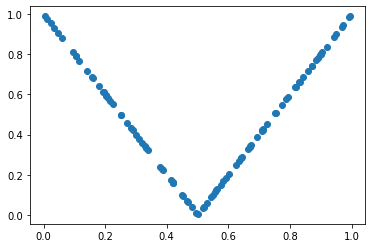

In [6]:
x_train = np.random.rand(100)
x_train = np.array(x_train, dtype=np.float32)

#y_train = x_train**2
y_train = 2*np.abs(x_train-0.5)
y_train = np.array(y_train, dtype=np.float32)

plt.scatter(x_train,y_train)
np.shape(x_train),np.shape(y_train)

In [0]:
qc = TorchCircuit.apply 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.h1 = nn.Linear(1, 5)
        self.h2 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.relu(self.h1(x))
        x = self.h2(x)
        x = qc(x)
        x = (x+1)/2  
        return x

In [0]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=0.001)
loss_list = []

In [14]:
epochs = 100
for epoch in range(epochs):
    total_loss = []
    for batch_idx in range(100):
        optimizer.zero_grad()
        target=torch.tensor(np.reshape(y_train[batch_idx],(1,1)),dtype=torch.double)
        data=torch.tensor(np.reshape(x_train[batch_idx],(1,1)),dtype=torch.float)
        output = network(data)

        loss = F.binary_cross_entropy(output,target) #F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print(np.round(loss_list[-1],3),end=' ')

0.52 0.515 0.513 0.513 0.511 0.514 0.512 0.511 0.511 0.511 0.512 0.508 0.512 0.509 0.511 0.511 0.507 0.509 0.509 0.506 0.507 0.51 0.508 0.508 0.508 0.507 0.507 0.509 0.508 0.507 0.507 0.507 0.508 0.507 0.506 0.507 0.506 0.506 0.507 0.508 0.508 0.506 0.508 0.507 0.507 0.506 0.506 0.508 0.505 0.507 0.508 0.508 0.507 0.507 0.507 0.51 0.507 0.509 0.508 0.507 0.507 0.508 0.508 0.508 0.508 0.507 0.506 0.507 0.509 0.506 0.509 0.507 0.506 0.506 0.509 0.508 0.508 0.507 0.507 0.509 0.508 0.506 0.508 0.507 0.507 0.507 0.508 0.508 0.508 0.507 0.507 0.508 0.508 0.508 0.508 0.508 0.507 0.508 0.507 0.509 

Text(0, 0.5, 'Loss')

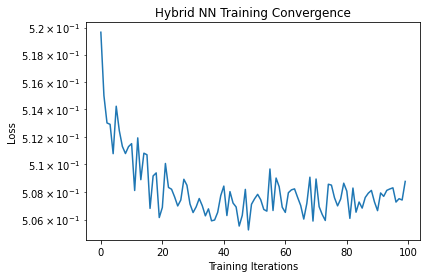

In [15]:
plt.semilogy(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel('Training Iterations')
plt.ylabel('Loss')

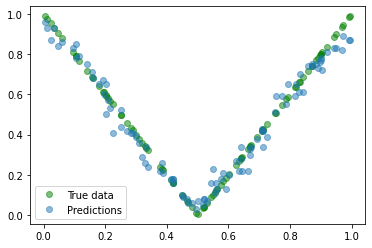

In [16]:
with torch.no_grad(): # we don't need gradients in the testing phase
    predicted_list = []
    for i in range(100):
      data=torch.tensor(np.reshape(x_train[i],(1,1)),dtype=torch.float)
      predicted = network(data).data.numpy()
      predicted_list.append(predicted)

plt.clf()
plt.plot(x_train, y_train, 'go', label='True data', alpha=0.5)
plt.plot(x_train, np.reshape(predicted_list,-1), 'o', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()